<a href="https://colab.research.google.com/github/vikasg964/Stock_price_forcasting/blob/main/Time_Forcasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading the dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

%matplotlib inline

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import io
import requests
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from sklearn import metrics

Helper Functions

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

    # Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

Loading the data csv file

In [ ]:
df_stock = pd.read_csv('/content/CSC215_P2_Stock_Price.csv')

In [ ]:
df_stock.shape

(4392, 7)

In [ ]:
df_stock.head

<bound method NDFrame.head of            Date        Open        High  ...       Close   Adj_Close   Volume
0     2000/3/27    3.812500    4.156250  ...    4.125000    4.125000  3675600
1     2000/3/28    4.125000    4.125000  ...    4.015625    4.015625  1077600
2     2000/3/29    4.000000    4.031250  ...    4.000000    4.000000   437200
3     2000/3/30    4.000000    4.000000  ...    3.843750    3.843750  1883600
4     2000/3/31    3.734375    3.734375  ...    3.390625    3.390625  7931600
...         ...         ...         ...  ...         ...         ...      ...
4387   2017/9/1  113.790001  114.099998  ...  113.309998  113.309998   950000
4388   2017/9/5  112.519997  113.529999  ...  111.870003  111.870003  1805200
4389   2017/9/6  112.029999  112.489998  ...  112.230003  112.230003  2136700
4390   2017/9/7  112.459999  112.900002  ...  112.339996  112.339996  1251600
4391   2017/9/8  112.300003  114.790001  ...  113.190002  113.190002  1611700

[4392 rows x 7 columns]>

Drop Missing values

In [ ]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock

In [ ]:
df_stock_new.head

<bound method NDFrame.head of            Date        Open        High  ...       Close   Adj_Close   Volume
0     2000/3/27    3.812500    4.156250  ...    4.125000    4.125000  3675600
1     2000/3/28    4.125000    4.125000  ...    4.015625    4.015625  1077600
2     2000/3/29    4.000000    4.031250  ...    4.000000    4.000000   437200
3     2000/3/30    4.000000    4.000000  ...    3.843750    3.843750  1883600
4     2000/3/31    3.734375    3.734375  ...    3.390625    3.390625  7931600
...         ...         ...         ...  ...         ...         ...      ...
4387   2017/9/1  113.790001  114.099998  ...  113.309998  113.309998   950000
4388   2017/9/5  112.519997  113.529999  ...  111.870003  111.870003  1805200
4389   2017/9/6  112.029999  112.489998  ...  112.230003  112.230003  2136700
4390   2017/9/7  112.459999  112.900002  ...  112.339996  112.339996  1251600
4391   2017/9/8  112.300003  114.790001  ...  113.190002  113.190002  1611700

[4392 rows x 7 columns]>

In [ ]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)

In [ ]:
df_stock_new.shape

(4392, 5)

In [ ]:
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [ ]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']
#print first 5 rows in new csv file
print(df_stock_new.head())

print("\nNumber of col/row currently:")
print("Data: ", df_stock_new.shape)

       Open      High       Low     Close   Volume         y
0  3.812500  4.156250  3.812500  4.125000  3675600  4.125000
1  4.125000  4.125000  4.000000  4.015625  1077600  4.015625
2  4.000000  4.031250  3.953125  4.000000   437200  4.000000
3  4.000000  4.000000  3.843750  3.843750  1883600  3.843750
4  3.734375  3.734375  3.390625  3.390625  7931600  3.390625

Number of col/row currently:
Data:  (4392, 6)


Normalize the features

In [ ]:
#Normalizing except  last column y
for column in df_stock_new.columns:
  if  column != 'y':
    encode_numeric_zscore(df_stock_new, column)

#print first  5 rows in new csv file to check for normalizing
print(df_stock_new.head())

       Open      High       Low     Close    Volume         y
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625


In [ ]:
# Set all column other than y as input or 'x'
x = df_stock_new.iloc[:,df_stock_new.columns != 'y']
x = np.array(x, dtype=np.float32)

# Set the y column as output or 'y'
y = np.array(df_stock_new['y'].values, dtype=np.float32)
print(x.shape)
print(y.shape)

(4392, 5)
(4392,)


In [ ]:
def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [ ]:
SEQUENCE_SIZE = 7
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)
x_lstseq, y_lstseq = to_sequences(SEQUENCE_SIZE, x, y)

#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of x_lstseq: {}".format(x_lstseq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))
print("Shape of y_lstseq: {}".format(y_lstseq.shape))

#reshaping the array
x_newseq=x_lstseq.reshape(4385,7,5)

#print("Shape of x_newseq: {}".format(y_lstm_seq_test.shape))
print("Shape of x_newseq: {}".format(x_newseq.shape))

Shape of x_lstseq: (4385, 7, 1, 5)
Shape of y_lstseq: (4385,)
Shape of x_newseq: (4385, 7, 5)


In [ ]:

x_seq_3d = x_lstseq.reshape(4385,7,5)

Split train and test data 70/30

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_3d,y_seq,test_size=0.30,random_state=0)

In [ ]:
X_train.shape

(3069, 7, 5)

In [ ]:

X_test.shape

(1316, 7, 5)

In [ ]:
Y_train.shape

(3069,)

In [ ]:
Y_test.shape

(1316,)

In [ ]:
type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

numpy.ndarray

LSTM




Model trained for "adam" optimizer and "relu" activation function : 

Epoch 1/200
96/96 - 1s - loss: 1100.9877 - val_loss: 302.5863
Epoch 2/200
96/96 - 1s - loss: 152.4775 - val_loss: 23.8968
Epoch 3/200
96/96 - 1s - loss: 17.6757 - val_loss: 10.6310
Epoch 4/200
96/96 - 1s - loss: 9.9268 - val_loss: 3.8631
Epoch 5/200
96/96 - 1s - loss: 6.0187 - val_loss: 3.1654
Epoch 6/200
96/96 - 1s - loss: 4.3161 - val_loss: 2.0493
Epoch 7/200
96/96 - 1s - loss: 4.4583 - val_loss: 2.0754
Epoch 8/200
96/96 - 1s - loss: 4.3936 - val_loss: 2.8586
Epoch 9/200
96/96 - 1s - loss: 3.9660 - val_loss: 2.9366
Epoch 10/200
96/96 - 1s - loss: 3.7185 - val_loss: 1.8306
Epoch 11/200
96/96 - 1s - loss: 3.8311 - val_loss: 2.0814
Epoch 12/200
96/96 - 1s - loss: 3.4810 - val_loss: 2.1083
Epoch 13/200
96/96 - 1s - loss: 3.4088 - val_loss: 2.6100
Epoch 14/200
96/96 - 1s - loss: 3.7959 - val_loss: 2.5824
Epoch 15/200
96/96 - 1s - loss: 3.3261 - val_loss: 1.8341
Epoch 00015: early stopping


Final score (MSE): 1.83059

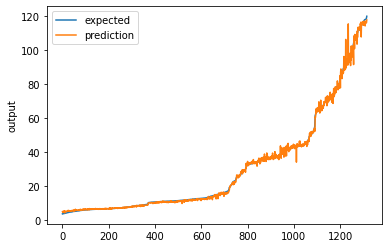




Model trained for "adam" optimizer and "sigmoid" activation function : 

Epoch 1/200
96/96 - 1s - loss: 1729.0018 - val_loss: 1578.9553
Epoch 2/200
96/96 - 1s - loss: 1543.5763 - val_loss: 1457.5417
Epoch 3/200
96/96 - 1s - loss: 1439.0481 - val_loss: 1365.4114
Epoch 4/200
96/96 - 1s - loss: 1353.7389 - val_loss: 1288.3523
Epoch 5/200
96/96 - 1s - loss: 1277.3613 - val_loss: 1214.9835
Epoch 6/200
96/96 - 1s - loss: 1204.8575 - val_loss: 1148.7948
Epoch 7/200
96/96 - 1s - loss: 1144.2052 - val_loss: 1093.2644
Epoch 8/200
96/96 - 1s - loss: 1090.6238 - val_loss: 1046.9056
Epoch 9/200
96/96 - 1s - loss: 1048.4855 - val_loss: 1010.5466
Epoch 10/200
96/96 - 1s - loss: 1015.1860 - val_loss: 980.6501
Epoch 11/200
96/96 - 1s - loss: 985.5242 - val_loss: 953.4443
Epoch 12/200
96/96 - 1s - loss: 960.8499 - val_loss: 934.0208
Epoch 13/200
96/96 - 1s - loss: 943.3941 - val_loss: 919.8475
Epoch 14/200
96/96 - 1s - loss: 844.4377 - val_loss: 755.8063
Epoch 15/200
96/96 - 1s - loss: 746.7536 - val

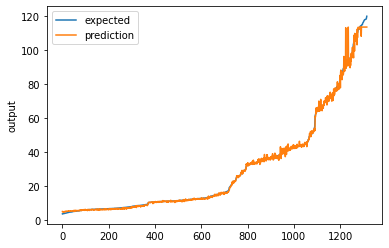




Model trained for "adam" optimizer and "tanh" activation function : 

Epoch 1/200
96/96 - 1s - loss: 1546.2350 - val_loss: 1332.8011
Epoch 2/200
96/96 - 1s - loss: 1290.1577 - val_loss: 1201.6343
Epoch 3/200
96/96 - 1s - loss: 1168.2974 - val_loss: 1077.2367
Epoch 4/200
96/96 - 1s - loss: 1049.3524 - val_loss: 972.0665
Epoch 5/200
96/96 - 1s - loss: 950.2117 - val_loss: 881.4961
Epoch 6/200
96/96 - 1s - loss: 863.6288 - val_loss: 801.6031
Epoch 7/200
96/96 - 1s - loss: 787.5251 - val_loss: 731.2625
Epoch 8/200
96/96 - 1s - loss: 720.1128 - val_loss: 668.8347
Epoch 9/200
96/96 - 1s - loss: 660.4778 - val_loss: 613.3560
Epoch 10/200
96/96 - 1s - loss: 607.5816 - val_loss: 564.3433
Epoch 11/200
96/96 - 1s - loss: 560.8004 - val_loss: 520.0573
Epoch 12/200
96/96 - 1s - loss: 518.6246 - val_loss: 481.0093
Epoch 13/200
96/96 - 1s - loss: 480.5018 - val_loss: 445.0957
Epoch 14/200
96/96 - 1s - loss: 445.6951 - val_loss: 412.4583
Epoch 15/200
96/96 - 1s - loss: 414.0127 - val_loss: 382.1293

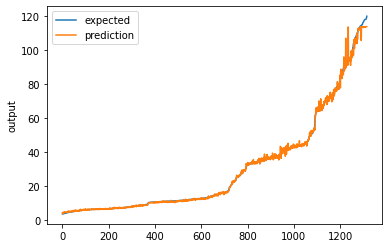




Model trained for "sgd" optimizer and "relu" activation function : 

Epoch 1/200
96/96 - 1s - loss: nan - val_loss: nan
Epoch 2/200
96/96 - 1s - loss: nan - val_loss: nan
Epoch 3/200
96/96 - 1s - loss: nan - val_loss: nan
Epoch 4/200
96/96 - 1s - loss: nan - val_loss: nan
Epoch 5/200
96/96 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 4391.512751126149
Final score (RMSE): 66.26848988113544


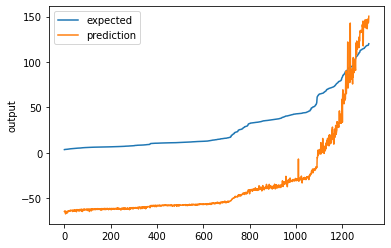




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Epoch 1/200
96/96 - 1s - loss: 221.9275 - val_loss: 26.7523
Epoch 2/200
96/96 - 1s - loss: 28.4307 - val_loss: 96.0170
Epoch 3/200
96/96 - 1s - loss: 20.5096 - val_loss: 4.5335
Epoch 4/200
96/96 - 1s - loss: 8.4044 - val_loss: 14.4432
Epoch 5/200
96/96 - 1s - loss: 9.0404 - val_loss: 10.9906
Epoch 6/200
96/96 - 1s - loss: 6.9284 - val_loss: 8.5970
Epoch 7/200
96/96 - 1s - loss: 5.5019 - val_loss: 5.4861
Epoch 8/200
96/96 - 1s - loss: 6.1209 - val_loss: 2.7095
Epoch 9/200
96/96 - 1s - loss: 5.1588 - val_loss: 2.8353
Epoch 10/200
96/96 - 1s - loss: 4.8995 - val_loss: 2.2362
Epoch 11/200
96/96 - 1s - loss: 4.4543 - val_loss: 5.1078
Epoch 12/200
96/96 - 1s - loss: 4.2892 - val_loss: 3.3173
Epoch 13/200
96/96 - 1s - loss: 4.1443 - val_loss: 3.2624
Epoch 14/200
96/96 - 1s - loss: 3.9675 - val_loss: 2.2587
Epoch 15/200
96/96 - 1s - loss: 3.8203 - val_loss: 2.6159
Epoch 00015: early stopping


Final score (MSE): 2.23617

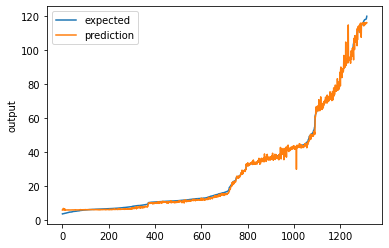




Model trained for "sgd" optimizer and "tanh" activation function : 

Epoch 1/200
96/96 - 1s - loss: 670.2385 - val_loss: 442.7309
Epoch 2/200
96/96 - 1s - loss: 262.3752 - val_loss: 276.2396
Epoch 3/200
96/96 - 1s - loss: 198.7172 - val_loss: 108.6841
Epoch 4/200
96/96 - 1s - loss: 120.3571 - val_loss: 67.9712
Epoch 5/200
96/96 - 1s - loss: 57.1996 - val_loss: 38.0109
Epoch 6/200
96/96 - 1s - loss: 45.8561 - val_loss: 22.7720
Epoch 7/200
96/96 - 1s - loss: 85.0637 - val_loss: 47.0585
Epoch 8/200
96/96 - 1s - loss: 36.1881 - val_loss: 43.1155
Epoch 9/200
96/96 - 1s - loss: 47.7667 - val_loss: 23.0159
Epoch 10/200
96/96 - 1s - loss: 29.9474 - val_loss: 19.0920
Epoch 11/200
96/96 - 1s - loss: 50.2467 - val_loss: 36.7073
Epoch 12/200
96/96 - 1s - loss: 29.7395 - val_loss: 13.9922
Epoch 13/200
96/96 - 1s - loss: 32.8561 - val_loss: 37.4188
Epoch 14/200
96/96 - 1s - loss: 26.4263 - val_loss: 18.6382
Epoch 15/200
96/96 - 1s - loss: 21.1157 - val_loss: 30.3653
Epoch 16/200
96/96 - 1s - loss

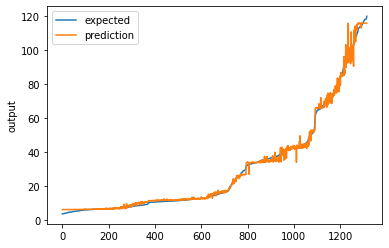

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics

optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        model = Sequential()

        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7,5)))
        model.add(Dense(32, activation=act))
        model.add(Dense(32, activation=act))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer=opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
        model.load_weights('best_weights_LSTM.hdf5')

        pred = model.predict(X_test)
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)